In [2]:
#loading important libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import dateutil
import seaborn as sns
sns.set()  #to override matplotlip with beautiful seaborn graphs
%matplotlib inline 

In [3]:
#reading the dataset 
data = pd.read_csv('AirPassengers.csv') 

In [4]:
data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [5]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
data.shape

(144, 2)

In [7]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [8]:
#preprocessing 
data=data.rename(columns = {'Month':'Datetime'})

In [9]:
#data.timestamp = pd.to_datetime(data.Date , format = '%Y-%m') 
data['Datetime'] = data['Datetime'].apply(dateutil.parser.parse, dayfirst=False)

In [10]:
data['Year']=data.Datetime.dt.year
#data['Month']=data.Datetime.dt.month_name(locale = 'English')
data['Month']=data.Datetime.dt.month_name()

In [11]:
passenger_pivot_table = data.pivot('Month', 'Year', '#Passengers')
passenger_pivot_table

Year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
Month,,,,,,,,,,,,
April,129,135,163,181,235,227,269,313,348,348,396,461
August,148,170,199,242,272,293,347,405,467,505,559,606
December,118,140,166,194,201,229,278,306,336,337,405,432
February,118,126,150,180,196,188,233,277,301,318,342,391
January,112,115,145,171,196,204,242,284,315,340,360,417
July,148,170,199,230,264,302,364,413,465,491,548,622
June,135,149,178,218,243,264,315,374,422,435,472,535
March,132,141,178,193,236,235,267,317,356,362,406,419
May,121,125,172,183,229,234,270,318,355,363,420,472


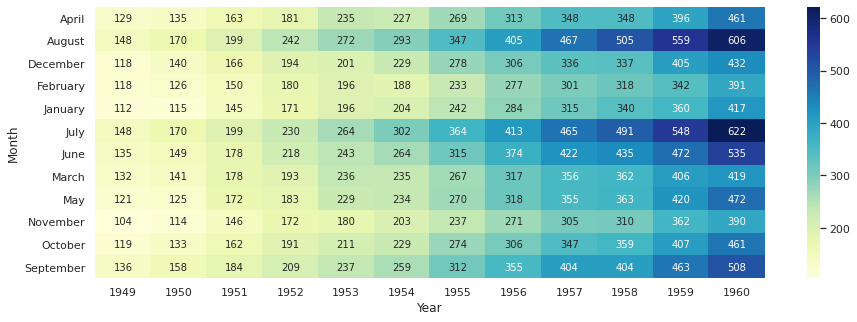

In [12]:
plt.figure(figsize=(15,5))
sns.heatmap(passenger_pivot_table,annot=True, fmt='d', cmap= 'YlGnBu')
plt.show()

In [13]:
data['Date'] = data['Datetime'].map(lambda x: x.strftime('%Y-%m'))

In [14]:
data = data.drop('Year', axis=1)
data = data.drop('Month', axis=1)
data = data.drop('Datetime', axis=1)

In [15]:
data.timestamp = pd.to_datetime(data.Date , format = '%Y-%m') 
data.index = data.timestamp 
data.drop('Date',axis = 1, inplace = True) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [16]:
#looking at the first few rows 
data.head() 

,#Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


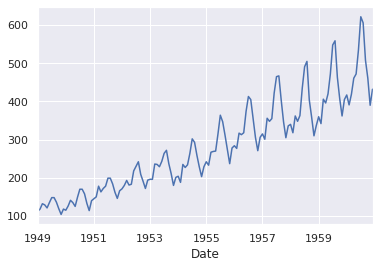

In [17]:
#Visualisevthe data to understand the pattern
data['#Passengers'].plot()

It can be seen from the graph that there is seasonality and trend, thus passenger number increases at a particular time of the year and lowers at another and also the passenger number increases as the years pass by. Therefore the series is not stationary.

Statistics tests are taken below to confirm to this observation.

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data, model='multiplicative')

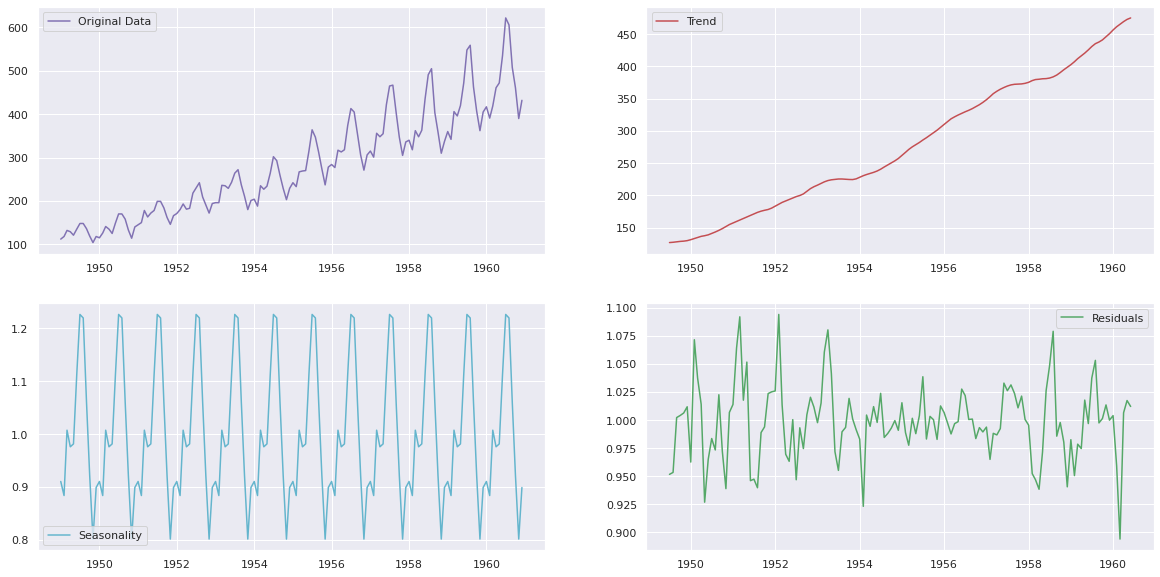

In [19]:
plt.figure(figsize=(20,10))

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(data, 'm',label="Original Data")
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend, 'r',label='Trend')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(seasonality, 'c', label='Seasonality')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(residual, 'g',label='Residuals')
plt.legend(loc='best')

plt.show()


Statistics test

In [20]:
#define function for ADF test 
from statsmodels.tsa.stattools import adfuller 
def adf_test(timeseries): 
    #Perform Dickey-Fuller test:     
    print('Results of Dickey-Fuller Test:')     
    dftest = adfuller(timeseries, autolag='AIC')     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])     
    for key,value in dftest[4].items():        
        dfoutput['Critical Value (%s)'%key] = value     
        print (dfoutput) 
#apply adf test on the series  
adf_test(data['#Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
dtype: float64
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
dtype: float64
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


The test statistic (0.815369) is higher than the critical values. Also, the p-value (0.99) is greater than 0.5 . We therefore fail to reject the null hypothesis and for that matter the series is not stationary.

In [21]:
#define function for kpss test 
from statsmodels.tsa.stattools import kpss 
#define KPSS 
def kpss_test(timeseries):    
    print('Results of KPSS Test:')    
    kpsstest = kpss(timeseries, regression='c')    
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])    
    for key,value in kpsstest[3].items():    
        kpss_output['Critical Value (%s)'%key] = value 
        print (kpss_output)

In [22]:
 kpss_test(data['#Passengers'])

Results of KPSS Test:
Test Statistic           1.052175
p-value                  0.010000
Lags Used               14.000000
Critical Value (10%)     0.347000
dtype: float64
Test Statistic           1.052175
p-value                  0.010000
Lags Used               14.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
dtype: float64
Test Statistic            1.052175
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64
Test Statistic            1.052175
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1882: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Since the test statistic is greater than the Critical values, we reject the null hypothesis thus the series is not stationary.

In [23]:
#divide into train and validation set 
train = data[:int(0.7*(len(data)))] 
valid = data[int(0.7*(len(data))):] 

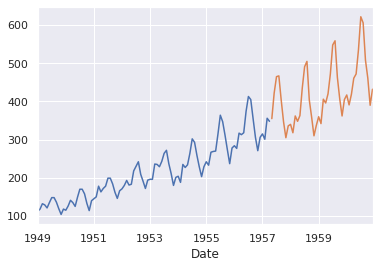

In [24]:
#plotting the data 
train['#Passengers'].plot() 
valid['#Passengers'].plot()

In [1]:
#!pip install pmdarima

In [34]:
import pmdarima as pm
model = pm.auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.18 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=645.940, Time=0.29 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Sun, 31 Jan 2021   AIC                            644.203
Time:                                    03:02:48   BIC                            651.601
Sample:                                         0   HQIC                           647.182
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.97   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

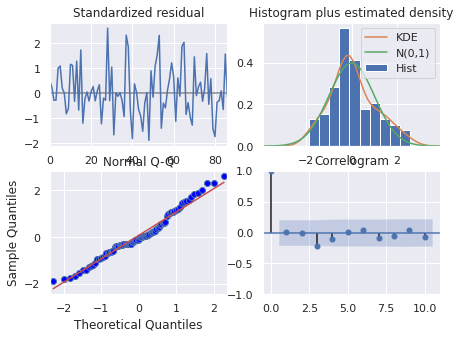

In [27]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [35]:
prediction, confint = model.predict(n_periods=len(valid), return_conf_int=True)

#prediction  = model.predict(n_periods=len(valid)) 
prediction = pd.DataFrame(prediction,index = valid.index,columns=['Prediction']) 

In [36]:
# make series for plotting purpose
#fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=valid.index)
upper_series = pd.Series(confint[:, 1], index=valid.index)

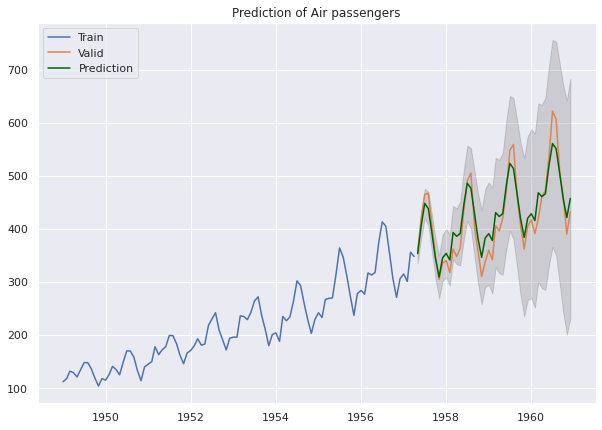

In [37]:
# Plot
plt.figure(figsize=(10,7))
plt.plot(train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(prediction,  color='darkgreen',label='Prediction') 
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc='upper left')
plt.title("Prediction of Air passengers")
plt.show()

# MODEL EVALUATION

In [38]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
mean_absolute_percentage_error(valid, prediction)

5.211788508523941

The Mean Absolute Percentage Error at 5.1 indicates that the model is 94.9% accurate in making 44 predictions

In [40]:
from sklearn.metrics import r2_score
r2_score(valid, prediction)

0.8824879929094841

The r2 score says, there is 88% correlation lies between the valid data and the predicted data

In [41]:
#fit the whole data before forcasting the future
model = pm.auto_arima(data,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

model.fit(data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.37 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.85 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.46 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=5.96 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.52 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.66 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.14 sec
 ARIMA(0,1,1)(3,1,0)[12]     

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [42]:
# Forecast passenger numbers for the next 2 years
n_periods = 24


forecast, confint = model.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = np.arange(len(data['#Passengers']), len(data['#Passengers'])+n_periods)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

In [43]:

# make series for plotting purpose
forecast_series = pd.Series(forecast, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

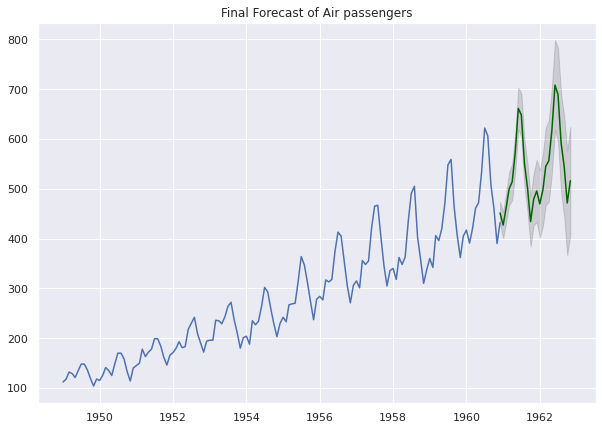

In [44]:
# Plot
plt.figure(figsize=(10,7))
plt.plot(data, label='Actual') 
plt.plot(forecast_series,  color='darkgreen',label='Forecast') 
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast of Air passengers")
plt.show()

In [45]:
forecast_series

1960-12-01    451.347077
1961-01-01    427.102222
1961-02-01    463.382490
1961-03-01    499.705771
1961-04-01    514.035526
1961-05-01    571.851867
1961-06-01    661.310509
1961-07-01    648.081675
1961-08-01    551.284691
1961-09-01    501.068279
1961-10-01    434.052984
1961-11-01    479.233768
1961-12-01    495.569171
1962-01-01    469.578456
1962-02-01    497.955024
1962-03-01    544.916438
1962-04-01    556.350007
1962-05-01    616.910052
1962-06-01    708.165788
1962-07-01    689.435153
1962-08-01    592.107044
1962-09-01    544.008548
1962-10-01    471.532195
1962-11-01    516.127935
Freq: MS, dtype: float64